# CS342 Final Project
### Dayou Ren; Spencer Petty
### dr37269; sap3758

In this project, we will be building and training an autoencoder architecture to generate images of CS professor. We are basically asking this question: "what does a neural network believe a CS professor should look like?"

In [4]:
import cv2
from PIL import Image
import numpy as np
import torchvision
import pickle
import os

In [5]:
# Define the desired dimensions for the cropped and resized images
crop_size = (500, 500)

In [6]:
def crop_profs():
    # Open each headshot image and crop it to the desired size
    for i in range(1, 6):
        # Replace 'image_path' with the actual file path of the image
        image_path = f'./CS_prof_images/image_{i}.jpg'
        img = cv2.imread(image_path)

        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect all the faces in the image
        faces = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml").detectMultiScale(gray, scaleFactor=1.3, minNeighbors=3)

        # Crop the image based on the location of the first detected face
        if len(faces) > 0:
            x, y, w, h = faces[0]
            face_image = gray[y:y+h, x:x+w]

            # Resize the cropped image to the desired dimensions
            resized_img = cv2.resize(face_image, crop_size)

            # Convert the resized image to RGB
            rgb_resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

            # Save the resized image with the original file name
            output_path = f'./cropped_CS_prof_images/resized_image_{i}.jpg'
            Image.fromarray(rgb_resized_img).save(output_path)
        else:
            print(f"No face detected in image {i}. Skipping.")


In [7]:
def crop_database():
    # Open each headshot image and crop it to the desired size
    for i in range(1, 13234):
        # Replace 'image_path' with the actual file path of the image
        image_path = f'./lfw/image_{i}.jpg'
        img = cv2.imread(image_path)

        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Detect all the faces in the image
        faces = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml").detectMultiScale(gray, scaleFactor=1.3, minNeighbors=3)

        # Crop the image based on the location of the first detected face
        if len(faces) > 0:
            x, y, w, h = faces[0]
            face_image = gray[y:y+h, x:x+w]

            # Resize the cropped image to the desired dimensions
            resized_img = cv2.resize(face_image, crop_size)

            # Convert the resized image to RGB
            rgb_resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

            # Save the resized image with the original file name
            output_path = f'./cropped_lfw/resized_image_{i}.jpg'
            Image.fromarray(rgb_resized_img).save(output_path)
        else:
            print(f"No face detected in image {i}. Skipping.")

In [8]:
def crop_nonface():
    # Set the target size for the cropped images
    target_size = (500, 500)

    # Set the path to the folder containing the images to be cropped
    folder_path = "./cropped_lfw/Non_Faces"

    # Loop through all the files in the folder
    for filename in os.listdir(folder_path):
        # Make sure the file is an image
        if filename.endswith(".jpg"):
            # Open the image and get its size
            image_path = os.path.join(folder_path, filename)
            with Image.open(image_path) as image:
                width, height = image.size
                # Calculate the crop area
                left = (width - target_size[0]) / 2
                top = (height - target_size[1]) / 2
                right = (width + target_size[0]) / 2
                bottom = (height + target_size[1]) / 2
                # Crop the image
                cropped_image = image.crop((left, top, right, bottom))
                # Save the cropped image
                cropped_image.save(image_path)

# Variational Autoencoder Class

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt


In [10]:
image_size = crop_size[0] * crop_size[1] * 3

class VAE(nn.Module):
    def __init__(self, latent_dims, hidden_nodes):
        super().__init__()
        # Encoding
        self.encode1  = nn.Conv2d(in_channels = 3, out_channels = 4, kernel_size = (32,32))
        self.encode2 = nn.MaxPool2d(kernel_size = (2,2), stride = 1)
        self.encode3  = nn.Linear(876096, hidden_nodes)                  
        self.encode_mu = torch.nn.Linear(hidden_nodes, latent_dims)
        self.encode_sigma = torch.nn.Linear(hidden_nodes, latent_dims)

        # Decoding
        self.decode1 = torch.nn.Linear(latent_dims, hidden_nodes)
        self.decode2 = torch.nn.Linear(hidden_nodes, image_size)

        # Other data
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0
        self.dims = latent_dims

    def forward(self, x):
        relu = torch.nn.ReLU()
        sigmoid = torch.nn.Sigmoid()
        # Encoding
        x = self.encode1(x)
        x = relu(self.encode2(x))
        x = torch.flatten(x, start_dim = 1, end_dim = -1)
        x = relu(self.encode3(x))
        # Variational part of VAE
        mu = self.encode_mu(x)
        sigma = torch.exp(self.encode_sigma(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(torch.abs(sigma) + 1e-10) - 1/2).sum()

        #Decoding
        z = self.decode1(z)
        z = relu(z)
        z = self.decode2(z)
        x_hat = sigmoid(z)
        return torch.reshape(x_hat, (-1, 3, crop_size[0], crop_size[1]))
    
    def generate_face(self):
        mu = torch.rand(self.dims)
        sigma = torch.rand(self.dims)
        z = mu + sigma*self.N.sample(mu.shape)
        z = self.decode1(z)
        z = torch.nn.ReLU()(z)
        z = self.decode2(z)
        x_hat = torch.nn.Sigmoid()(z)
        plt.matshow(x_hat.squeeze().detach().reshape((crop_size[0], crop_size[1], -1)))
        return x_hat

In [11]:
# Test the syntax and dimensionality of the model on a few samples. Expect noise as output
def test_noise_generation(nodes = 64):
    model = VAE(10, nodes)
    i = np.random.choice(13234)
    image_path = f'./cropped_lfw/Faces/image_{i}.jpg'
    imgnp = cv2.imread(image_path)
    img = torch.reshape(torch.tensor(imgnp, dtype = torch.float32), (1, -1, crop_size[0], crop_size[1]))
    out = model(img)
    plt.imshow(imgnp)
    plt.matshow(out.squeeze().detach().reshape((crop_size[0], crop_size[1], -1)))

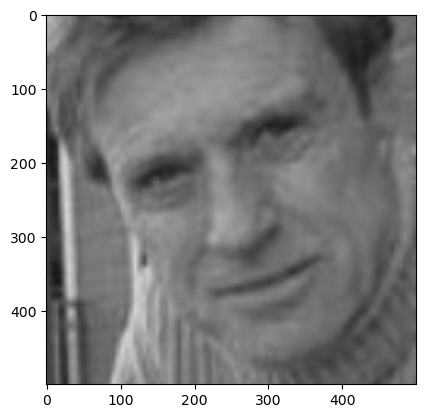

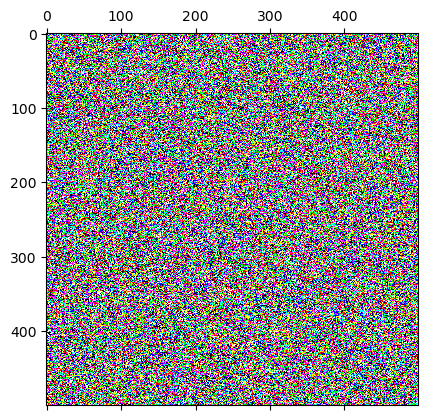

In [12]:
test_noise_generation()

In [13]:
# Doing in-place allows easier saving via pickle
def train_vae(model, dataloader, nepochs=100, inter_epoch  = True):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(nepochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            optimizer.zero_grad()
            x_hat = model(data)
            term1 = ((data - x_hat)**2).mean()
            term2 = model.kl
            loss = term1 + 1e-5*term2  
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            
            if inter_epoch and batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader),
                    loss.item() / len(data)))

        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(dataloader.dataset)))
                
            

In [14]:
def save_model(model, name = 'model.pkl'):
    pickle.dump(model, open(name, 'wb'))

In [20]:
def compare_outputs(model, pretrain = True):
    image_path = None
    if pretrain:
        i = np.random.choice(13234)
        image_path = f'./cropped_lfw/Faces/image_{i}.jpg'
    else:
        i = np.random.choice(97)
        image_path = f'./cropped_CS_prof_images/Faces/resized_image_{i}.jpg'
    imgnp = cv2.imread(image_path)
    img = torch.reshape(torch.tensor(imgnp, dtype = torch.float32), (1, -1, crop_size[0], crop_size[1]))
    out = model(img)
    plt.imshow(imgnp)
    plt.matshow(out.squeeze().detach().reshape((crop_size[0], crop_size[1], -1)))

In [16]:
nepochs_pre = 1
nepochs_main = 100
pretrainset = torchvision.datasets.ImageFolder('./cropped_lfw', transform=torchvision.transforms.ToTensor())
pretrainloader = torch.utils.data.DataLoader(pretrainset, batch_size=64, shuffle=True)
model = VAE(10, 64)
train_vae(model, pretrainloader, nepochs = nepochs_pre)
print(f'After {nepochs_pre}  epochs of pretraining')
compare_outputs(model)

Train Epoch: 0 [0/12844 (0%)]	Loss: 0.000786
Train Epoch: 0 [640/12844 (5%)]	Loss: 0.000700
Train Epoch: 0 [1280/12844 (10%)]	Loss: 0.000757
Train Epoch: 0 [1920/12844 (15%)]	Loss: 0.000689
Train Epoch: 0 [2560/12844 (20%)]	Loss: 0.000652
Train Epoch: 0 [3200/12844 (25%)]	Loss: 0.000615
Train Epoch: 0 [3840/12844 (30%)]	Loss: 0.000640
Train Epoch: 0 [4480/12844 (35%)]	Loss: 0.000657
Train Epoch: 0 [5120/12844 (40%)]	Loss: 0.000594
Train Epoch: 0 [5760/12844 (45%)]	Loss: 0.000606
Train Epoch: 0 [6400/12844 (50%)]	Loss: 0.000620
Train Epoch: 0 [7040/12844 (55%)]	Loss: 0.000625
Train Epoch: 0 [7680/12844 (60%)]	Loss: 0.000668
Train Epoch: 0 [8320/12844 (65%)]	Loss: 0.000559
Train Epoch: 0 [8960/12844 (70%)]	Loss: 0.000669
Train Epoch: 0 [9600/12844 (75%)]	Loss: 0.000615
Train Epoch: 0 [10240/12844 (80%)]	Loss: 0.000548
Train Epoch: 0 [10880/12844 (85%)]	Loss: 0.000586
Train Epoch: 0 [11520/12844 (90%)]	Loss: 0.000610
Train Epoch: 0 [12160/12844 (95%)]	Loss: 0.000593
Train Epoch: 0 [8800/1

KeyboardInterrupt: 

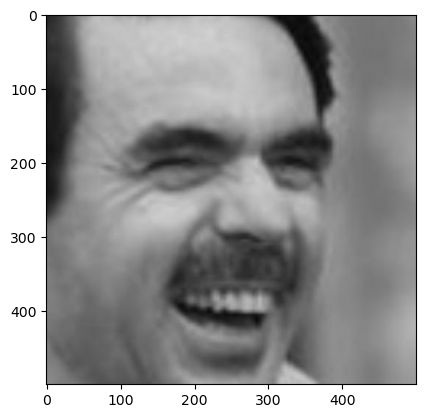

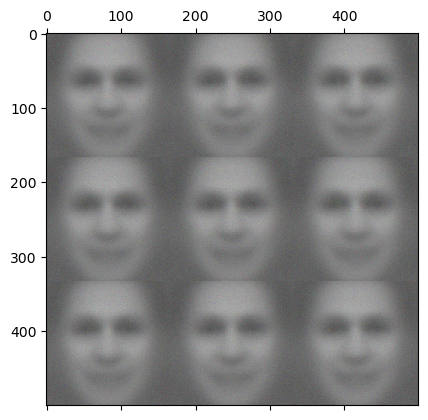

In [17]:
compare_outputs(model)

====> Epoch: 0 Average loss: 0.0011
====> Epoch: 1 Average loss: 0.0011
====> Epoch: 2 Average loss: 0.0011
====> Epoch: 3 Average loss: 0.0010
====> Epoch: 4 Average loss: 0.0010
====> Epoch: 5 Average loss: 0.0010
====> Epoch: 6 Average loss: 0.0010
====> Epoch: 7 Average loss: 0.0010
====> Epoch: 8 Average loss: 0.0010
====> Epoch: 9 Average loss: 0.0010
====> Epoch: 10 Average loss: 0.0009
====> Epoch: 11 Average loss: 0.0010
====> Epoch: 12 Average loss: 0.0010
====> Epoch: 13 Average loss: 0.0010
====> Epoch: 14 Average loss: 0.0009
====> Epoch: 15 Average loss: 0.0009
====> Epoch: 16 Average loss: 0.0010
====> Epoch: 17 Average loss: 0.0010
====> Epoch: 18 Average loss: 0.0009
====> Epoch: 19 Average loss: 0.0009
====> Epoch: 20 Average loss: 0.0009
====> Epoch: 21 Average loss: 0.0009
====> Epoch: 22 Average loss: 0.0009
====> Epoch: 23 Average loss: 0.0009
====> Epoch: 24 Average loss: 0.0009
====> Epoch: 25 Average loss: 0.0009
====> Epoch: 26 Average loss: 0.0009
====> Epoch

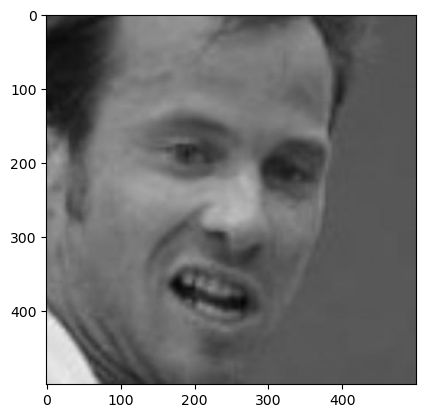

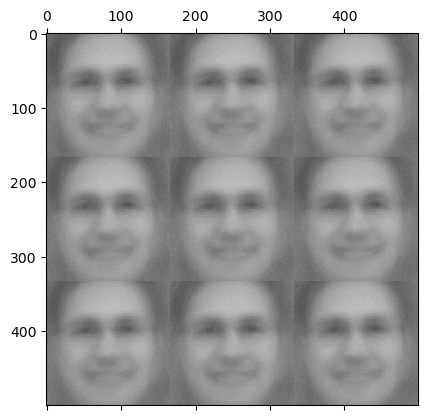

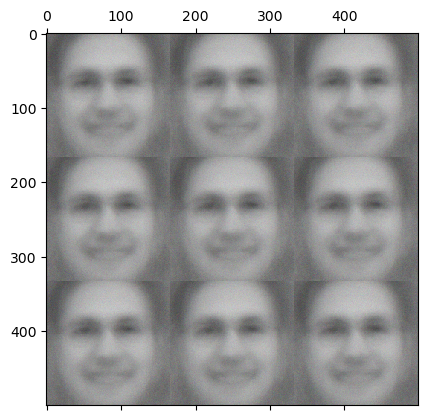

In [19]:
trainset  = torchvision.datasets.ImageFolder('./cropped_CS_prof_images', transform = torchvision.transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle=True)
train_vae(model, trainloader, nepochs = nepochs_main, inter_epoch=False)
print(f'After {nepochs_main} epochs of main training')
compare_outputs(model)
model.generate_face()
save_model(model, "convmodel.pkl")

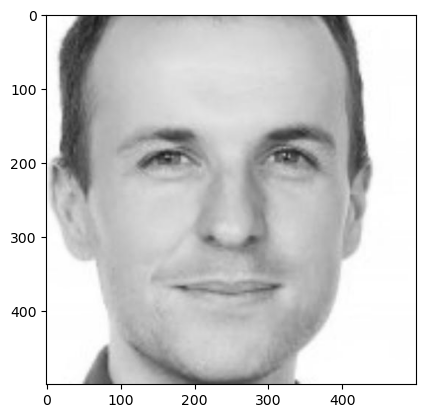

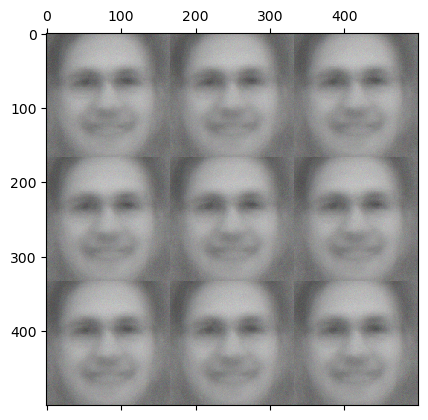

In [29]:
compare_outputs(model, pretrain = False)